# MobileNet - PBC Augmented Data v2 - Model Visualization
# 

In [61]:
import os, math, random, lime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
np.set_printoptions(precision=4, suppress=True, sign=" ")

In [3]:
# Import images
test_dir ="images/PBC Data/Test/"

test = ImageDataGenerator()
testdata = test.flow_from_directory(directory=test_dir, target_size=(224,224), shuffle = False)

classes = list(testdata.class_indices.keys())


Found 304 images belonging to 5 classes.


In [5]:
img_shape = (224, 224, 3)

model = keras.applications.MobileNet(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=img_shape,
    pooling='max',
    classes=6, alpha=1, depth_multiplier=2,dropout=.5)

print(model.summary())

model.load_weights('PBC Augmented Data - MobileNet v2.params')

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 64)      576       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 64

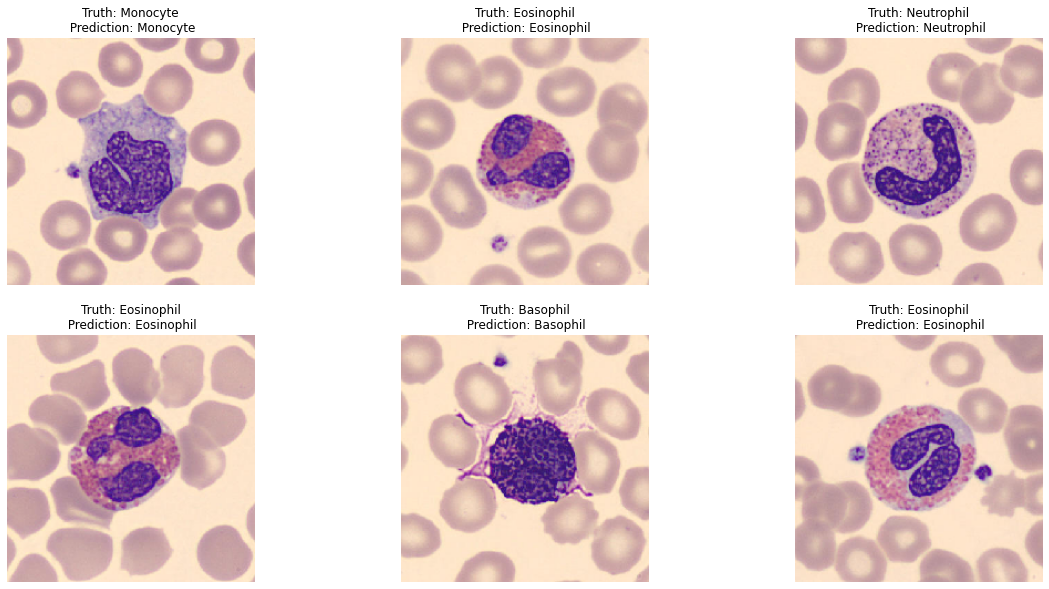

In [75]:
class Predictions:
    def __init__(self, n, directory, classes, model):  
        self.n = n
        self.file_names= [0] * n
        self.images = [0] * n
        self.preds = [0] * n
        self.truth = [0] * n
        self.classes = classes
        self.model = model
        
        self.get_images(self.n, directory)
    
    def get_images(self, n, directory):
        for x in range(n):
            # Pick a directory
            image_dir = random.choice(os.listdir(directory))
            
            # Pick a file
            file_name = random.choice(os.listdir(test_dir+"/"+image_dir))
            
            # Store file name and image class
            self.file_names[x]= test_dir+image_dir+"/"+file_name
            self.truth[x] = image_dir.title()
            
            # Load and store image
            img = image.load_img(test_dir+image_dir+"/"+file_name, target_size=(224, 224))
            self.images[x] = img # PIL.Image.Image image type

            # Convert Image to Appropriate Array Format
            img = self.img_4d(img)

            # Predict
            prediction = self.model.predict(img)
            self.preds[x] = self.classes[np.argmax(prediction[0], axis=0)].title()
        
        rows = int(math.ceil(self.n/3))
        cols = 3
        
        for i in range(self.n):
            plt.subplot(rows, cols, i+1)
            plt.rcParams["figure.figsize"] = (20,10)
            plt.imshow(self.images[i])
            plt.axis('off')
            plt.title("Truth: "+self.truth[i]+"\n Prediction: "+self.preds[i])
        
        plt.show()


    def img_3d(self, img):
        """ Input is Image, returns Image as (224, 224, 3) array (Which can be viewed in plt) """
        return np.asarray(img)        

    def img_4d(self, img):
        """ Input is Image, returns Image as (1, 224, 224, 3) array (Which classifier is expecting) """
        img = self.img_3d(img)
        return np.expand_dims(img, axis=0) 



# Let's see if we can identify a few images...
img_count = 6
my_predictions = Predictions(img_count, test_dir, classes, model)



  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


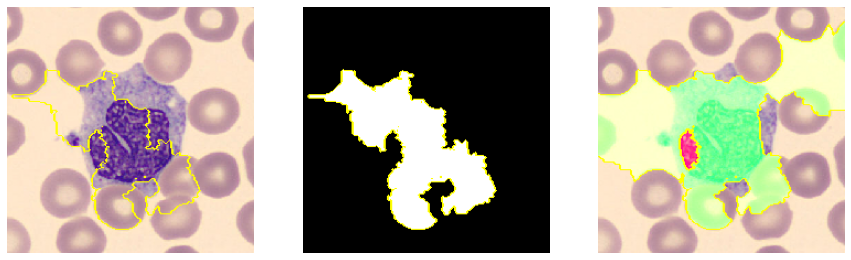

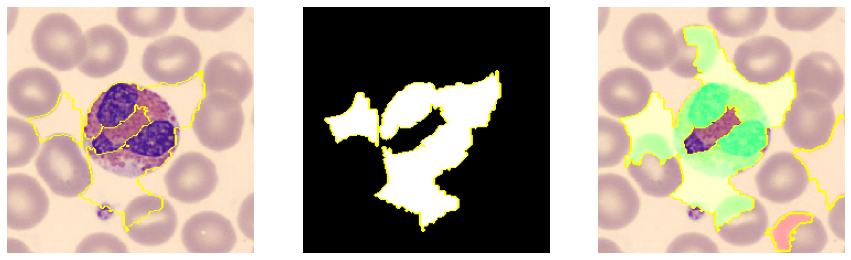

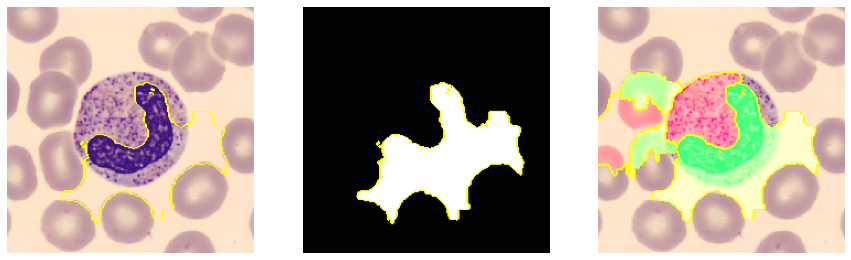

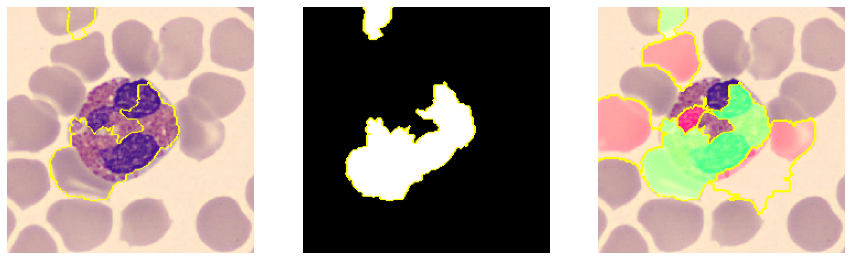

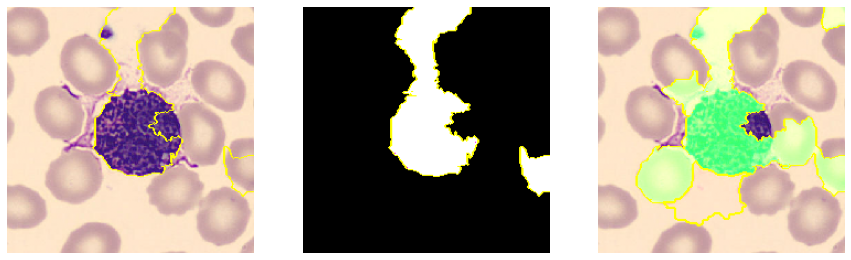

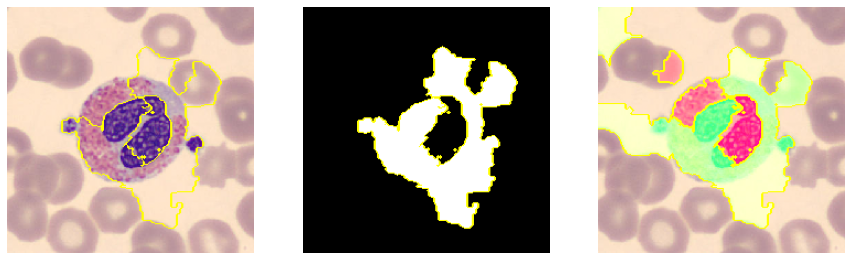

In [78]:
# Let's see how these identifications were made
for i in range(my_predictions.n):
    new_img = my_predictions.images[i]
    new_img_arr = my_predictions.img_3d(new_img)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(new_img_arr, model.predict)
    
    # The reason is that if the color intensity is a float, then matplotlib expects it to range from 0 to 1. 
    # If an int, then it expects 0 to 255. 
    # So you can either force all the numbers to int or scale them all by 1/255.

    temp_1, mask_1 = explanation.get_image_and_mask(
             model.predict(my_predictions.img_4d(new_img)).argmax(axis=1)[0],
             positive_only=True,
             hide_rest=False)

    temp_2, mask_2 = explanation.get_image_and_mask(
            explanation.top_labels[0], 
            positive_only=True, 
            num_features=5, 
            hide_rest=True)

    temp_3, mask_3 = explanation.get_image_and_mask(
            explanation.top_labels[0], 
            positive_only=False, 
            num_features=10, 
            hide_rest=False)


    fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15,15))
    plt1.imshow(mark_boundaries(temp_1, mask_1))
    plt2.imshow(mark_boundaries(temp_2, mask_2))
    plt3.imshow(mark_boundaries(temp_3, mask_3))
    plt1.axis('off')
    plt2.axis('off')
    plt3.axis('off')
    


(1, 224, 224, 3)
[[[ 0.7686  0.6     0.6353]
  [ 0.7651  0.5964  0.6317]
  [ 0.7608  0.5922  0.6275]
  ...
  [ 0.759   0.5943  0.6   ]
  [ 0.7447  0.5797  0.5961]
  [ 0.7384  0.5698  0.5961]]

 [[ 0.7686  0.6     0.6353]
  [ 0.7651  0.5964  0.6317]
  [ 0.7608  0.5922  0.6275]
  ...
  [ 0.759   0.5943  0.6   ]
  [ 0.7447  0.5797  0.5961]
  [ 0.7384  0.5698  0.5961]]

 [[ 0.7686  0.6     0.6353]
  [ 0.7651  0.5964  0.6317]
  [ 0.7608  0.5922  0.6275]
  ...
  [ 0.759   0.5943  0.6   ]
  [ 0.7447  0.5797  0.5961]
  [ 0.7384  0.5698  0.5961]]

 ...

 [[ 0.9598  0.85    0.7576]
  [ 0.9705  0.8607  0.7703]
  [ 0.9846  0.8748  0.7897]
  ...
  [ 0.772   0.5951  0.6641]
  [ 0.788   0.6077  0.6548]
  [ 0.806   0.6274  0.6472]]

 [[ 0.906   0.766   0.7644]
  [ 0.9452  0.8148  0.7744]
  [ 0.982   0.8625  0.7817]
  ...
  [ 0.7624  0.5899  0.6408]
  [ 0.7691  0.5962  0.6472]
  [ 0.7762  0.6025  0.651 ]]

 [[ 0.8623  0.7224  0.7254]
  [ 0.9125  0.7788  0.7424]
  [ 0.965   0.8454  0.7647]
  ...
  [ 0.7

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 223.5, 223.5, -0.5)

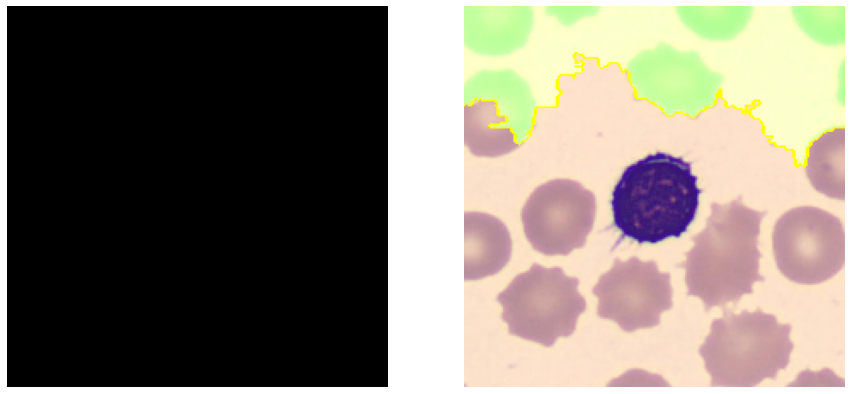

In [71]:
import skimage.io as iio
from tensorflow.keras.preprocessing import image

url = my_predictions.file_names[2]

def read_and_transform_img(url):
    img = iio.imread(url)
    img = skimage.transform.resize(img, (224,224))
    img = image.img_to_array(img) #3d
    img = np.expand_dims(img, axis=0) #4d
    return img

images = read_and_transform_img(url) #so this is a 4d tensor

#preds = model.predict(images)
#print(preds)
#prediction = np.argmax(preds)
#print(prediction)
#pct = np.max(preds)
#print(pct)

print(images.shape) # (1, 224, 224, 3)
print(images[0].astype('double'))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model.predict)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')